In [21]:
import matplotlib.pyplot as plt
import warnings
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error,mean_squared_log_error
from sklearn.svm import SVR
# from sklearn.utils import column_or_id

warnings.filterwarnings('ignore')

In [92]:
df = pd.read_csv('../datasets/Microsoft_Stock.csv',parse_dates=['Date'])
df = df.set_index("Date").to_period('H')

remove_cols = ['Open','High','Low','Volume']
df.drop(columns=remove_cols,inplace=True)

In [23]:
df['Timestamp']  = pd.to_datetime(df.index).astype(np.int64)/10**9
df_index= df.index
df_open = df['Close'].values.reshape(-1,1)
df.head()

df

,Close,Timestamp
Date,,
2015-04-01 16:00:00,40.72,1.427904e+09
2015-04-02 16:00:00,40.29,1.427990e+09
2015-04-06 16:00:00,41.55,1.428336e+09
2015-04-07 16:00:00,41.53,1.428422e+09
2015-04-08 16:00:00,41.42,1.428509e+09
...,...,...
2021-03-25 16:00:00,232.34,1.616688e+09
2021-03-26 16:00:00,236.48,1.616774e+09
2021-03-29 16:00:00,235.24,1.617034e+09


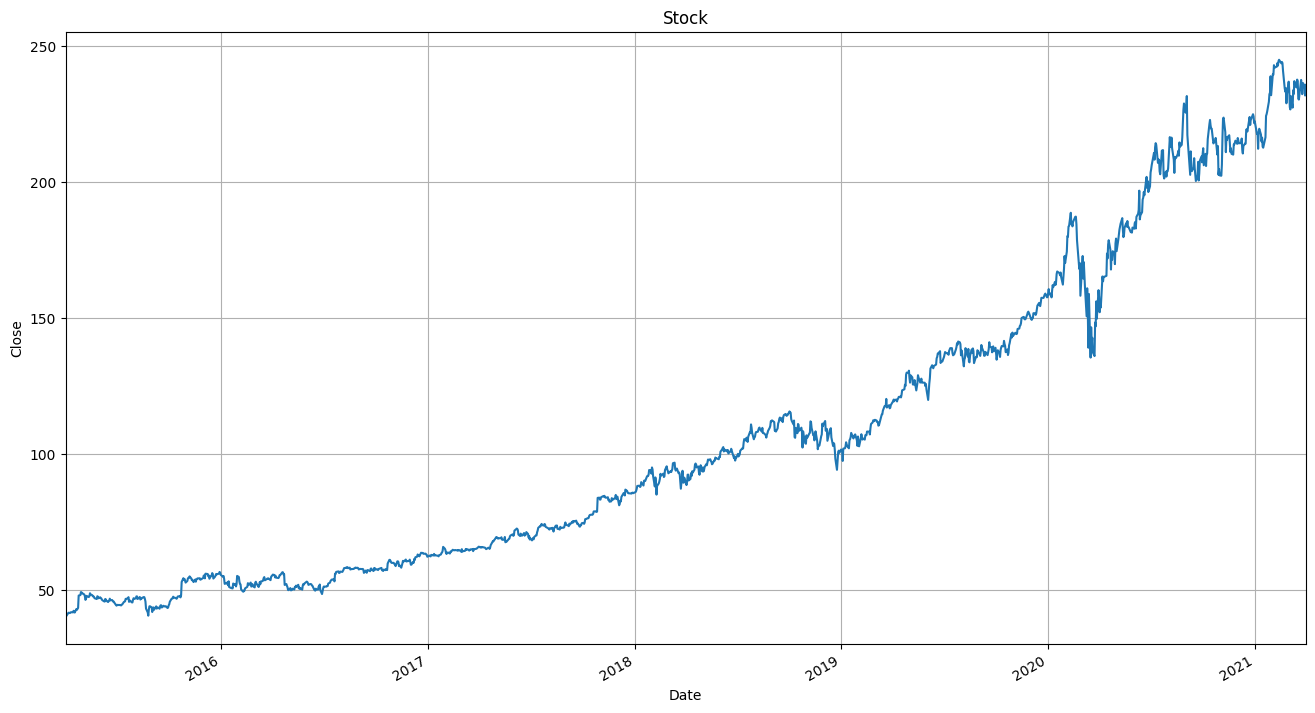

In [24]:
title = 'Stock'
xlabel='Date'
ylabel ='Close'

ax = df['Close'].plot(figsize=(16,9),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel,ylabel=ylabel)
ax.grid(True)

In [25]:
LR_sc = StandardScaler()

df_scaled = df.copy()
df_scaled['Close'] = LR_sc.fit_transform(df_open)
df_scaled

,Close,Timestamp
Date,,
2015-04-01 16:00:00,-1.176745,1.427904e+09
2015-04-02 16:00:00,-1.184331,1.427990e+09
2015-04-06 16:00:00,-1.162103,1.428336e+09
2015-04-07 16:00:00,-1.162456,1.428422e+09
2015-04-08 16:00:00,-1.164396,1.428509e+09
...,...,...
2021-03-25 16:00:00,2.203778,1.616688e+09
2021-03-26 16:00:00,2.276815,1.616774e+09
2021-03-29 16:00:00,2.254939,1.617034e+09


In [26]:
X_sc = StandardScaler()
y_sc = StandardScaler()

X = df.iloc[:,1].values.reshape(-1,1)
y = df.iloc[:,0].values.reshape(-1,1)

X_scaled = X_sc.fit_transform(X)
y_scaled = y_sc.fit_transform(y)

df_scaled = pd.DataFrame(index=df.index)

df_scaled['Timestamp'] = X_scaled
df_scaled['Close'] = y_scaled
df_scaled.head()

,Timestamp,Close
Date,,
2015-04-01 16:00:00,-1.729843,-1.176745
2015-04-02 16:00:00,-1.728264,-1.184331
2015-04-06 16:00:00,-1.721945,-1.162103
2015-04-07 16:00:00,-1.720365,-1.162456
2015-04-08 16:00:00,-1.718785,-1.164396


In [28]:
interrupt = int(len(df_scaled)*0.9)

train_data,test_data = df_scaled[:interrupt],df_scaled[interrupt:]
index_test = df_scaled.index[interrupt:]
print(train_data.shape)
print(test_data.shape)


(1359, 2)
(152, 2)


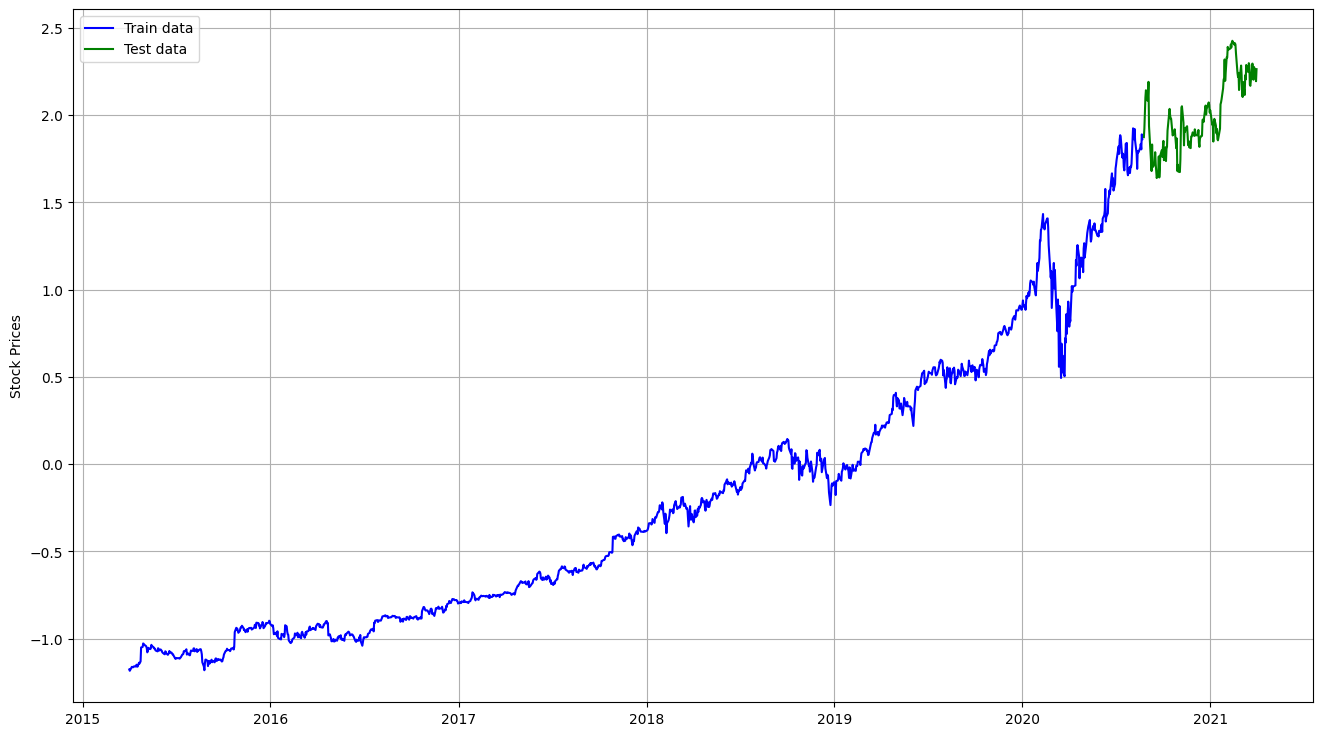

In [30]:
plt.figure(figsize=(16, 9)) 
plt.grid(True) 
plt.ylabel('Stock Prices')
plt.plot(train_data['Close'], 'blue', label='Train data') 
plt.plot(test_data['Close'], 'green' , label= 'Test data')
plt.legend()

In [47]:
def para_range (minimum, maximum, step):
    para_list = np.arange(minimum, maximum, step)
    return para_list

In [45]:
def print_stats(hyperparams, stats):
    
    if (hyperparams[0] == 'poly'):
        print( f'SVR(kernel={hyperparams[0]}, C={hyperparams[1]}, gamma={hyperparams[2]}, degree={hyperparams[3]}')

    else:
        print( f'SVR(kernel={hyperparams[0]}, C={hyperparams[1]}, gamma={hyperparams[2]} ')

    print( f"MAE={stats[0]:.2f} | MAPE={stats[1]:.2f} | MSE={stats[2] :.2f} | RMSE={stats[3]:.2f} ")
    
    stats_df = pd.DataFrame(columns=['kernel','C','gamma','degree','MAE','Mape','MSE','RMSE'])
    for ker in kernels:
        if(ker != 'poly'):
            for C in Cs:
                for gamma in gammas:
                    rgs = SVR(kernel=ker,C=C,gamma=gamma,verbose=False)
                    rgs.fit(X_train,y_train)
                    pred = rgs.predict(X_test)

                    inv_pred = y_sc.inverse_transform(
                        column_or_1d(pred).reshape(-1,1)
                    )
                    inv_test = y_sc.inverse_transform(
                        column_or_1d(y_test).reshape(-1,1)
                    )

                    mae = mean_absolute_error(inv_test,inv_pred)
                    mape = mean_absolute_percentage_error(inv_test,inv_pred)
                    mse = mean_absolute_error(inv_test,inv_pred)
                    rmse = np.sqrt(mse)

                    result = {'kernel':ker, 'C':C,'gamma':gamma,'degree':0,'MAE':mae,'MAPE':mape,'MSE':mse,'RMSE':rmse}

                    hyperparam = [ker,C,gamma,0]
                    stats = [mae,mape,mse,rmse]
                    stats_df = stats_df.append(result,ignore_index=True)
                    print_stats(hyperparam,stats)
        else:
            for gamma in gammas:
                    rgs = SVR(kernel=ker,C=C,gamma=gamma,degree=deg,verbose=False)
                    rgs.fit(X_train,y_train.reshape(-1,1))
                    pred = rgs.predict(X_test)

                    inv_pred = y_sc.inverse_transform(
                        column_or_1d(pred).reshape(-1,1)
                    )
                    inv_test = y_sc.inverse_transform(
                        column_or_1d(y_test).reshape(-1,1)
                    )

                    mae = mean_absolute_error(inv_test,inv_pred)
                    mape = mean_absolute_percentage_error(inv_test,inv_pred)
                    mse = mean_absolute_error(inv_test,inv_pred)
                    rmse = np.sqrt(mse)

                    result = {'kernel':ker, 'C':C,'gamma':gamma,'degree':deg,'MAE':mae,'MAPE':mape,'MSE':mse,'RMSE':rmse}

                    hyperparam = [ker,C,gamma,deg]
                    stats = [mae,mape,mse,rmse]
                    stats_df = stats_df.append(result,ignore_index=True)
                    print_stats(hyperparam,stats)

In [48]:
kernels = ['sigmoid','rbf','poly']
cs = para_range(0.01,0.2,0.1)
gammas = para_range(0.1,5,0.1)
degrees = para_range(1,6,1)

In [51]:
best_fit_model =stats_df[stats_df['MAPE'] == stats_df['MAPE'].min()].head(1)
best_fit_model

,kernel,C,gamma,degree,MAE,MAPE,MSE,RMSE


In [53]:
train_data

,Timestamp,Close
Date,,
2015-04-01 16:00:00,-1.729843,-1.176745
2015-04-02 16:00:00,-1.728264,-1.184331
2015-04-06 16:00:00,-1.721945,-1.162103
2015-04-07 16:00:00,-1.720365,-1.162456
2015-04-08 16:00:00,-1.718785,-1.164396
...,...,...
2020-08-17 16:00:00,1.374231,1.814599
2020-08-18 16:00:00,1.375811,1.835946
2020-08-19 16:00:00,1.377390,1.804367


In [54]:
test_data

,Timestamp,Close
Date,,
2020-08-24 16:00:00,1.385289,1.874758
2020-08-25 16:00:00,1.386869,1.923802
2020-08-26 16:00:00,1.388448,2.006366
2020-08-27 16:00:00,1.390028,2.102161
2020-08-28 16:00:00,1.391608,2.143266
...,...,...
2021-03-25 16:00:00,1.721761,2.203778
2021-03-26 16:00:00,1.723341,2.276815
2021-03-29 16:00:00,1.728080,2.254939


In [57]:
from sklearn.svm import SVR

model = SVR(kernel='rbf', C=1.0, epsilon=0.1)


In [69]:
X_train =train_date.iloc[:,0].values.reshape(-1,1)

In [70]:
y_train = train_date.iloc[:,1].values.reshape(-1,1)

In [72]:
X_test = test_date.iloc[:,0].values.reshape(-1,1)
y_test= test_date.iloc[:,1].values.reshape(-1,1)

In [71]:
model.fit(X_train,y_train)

SVR()

In [73]:
pred = model.predict(X_test)
pred

array([1.75688067, 1.76032098, 1.76375468, 1.7671817 , 1.77060199,
       1.7808218 , 1.78421451, 1.78760017, 1.79097873, 1.79435011,
       1.80776266, 1.81109725, 1.81442429, 1.81774372, 1.82765578,
       1.83094418, 1.83422467, 1.83749718, 1.84076165, 1.85050624,
       1.85373796, 1.85696134, 1.86017632, 1.86338284, 1.872951  ,
       1.87612306, 1.87928636, 1.88244083, 1.88558642, 1.89496928,
       1.89807873, 1.901179  , 1.90427003, 1.90735175, 1.91654053,
       1.91958446, 1.92261879, 1.92564347, 1.92865843, 1.93764447,
       1.94062   , 1.94358553, 1.946541  , 1.94948635, 1.95826112,
       1.96116542, 1.96405932, 1.96694277, 1.96981569, 1.97837081,
       1.98120111, 1.98402062, 1.98682927, 1.98962702, 1.99795427,
       2.00070784, 2.00345023, 2.00618139, 2.00890125, 2.01699259,
       2.01966676, 2.02232938, 2.0249804 , 2.02761975, 2.0354673 ,
       2.03805949, 2.04063975, 2.04544542, 2.05336042, 2.05586807,
       2.05836345, 2.0608465 , 2.06331717, 2.07065442, 2.07307

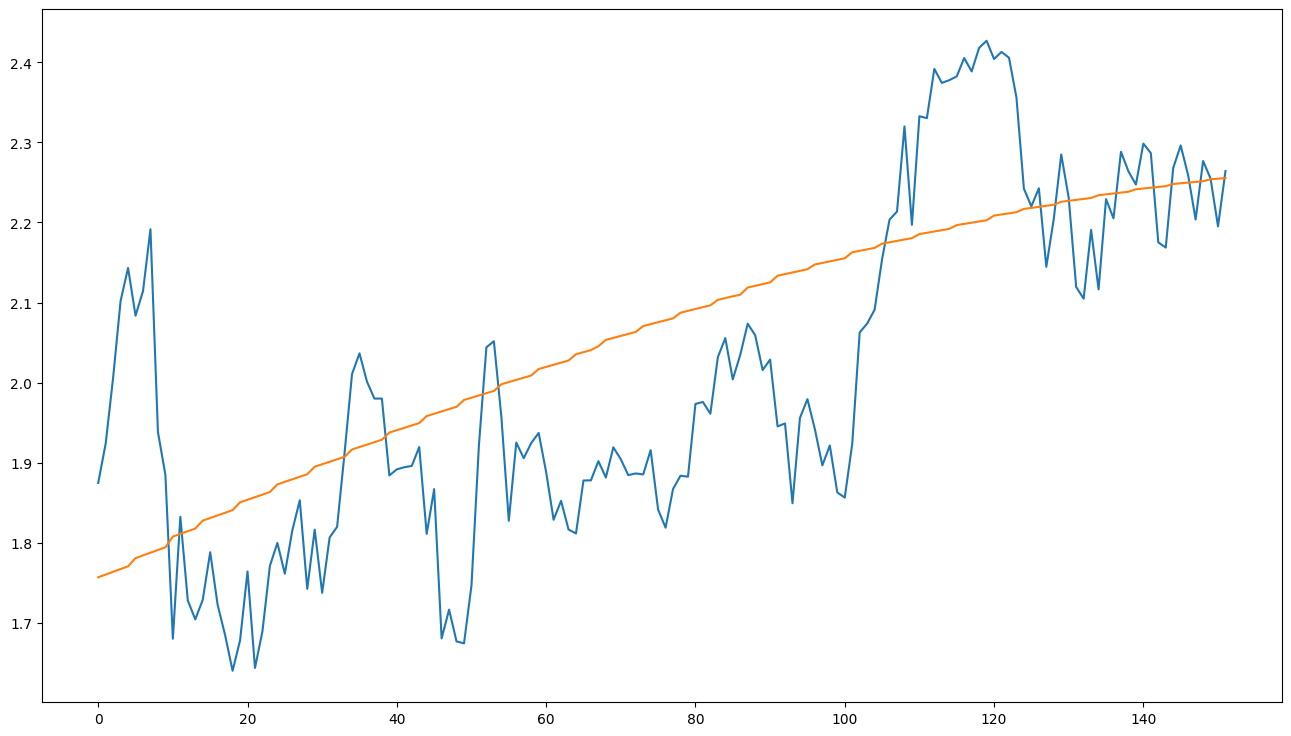

In [78]:
plt.figure(figsize=(16,9))
plt.plot(y_test)
plt.plot(model.predict(X_test))

In [80]:
#next 30 days

df.tail()

,Close,Timestamp
Date,,
2021-03-25 16:00:00,232.34,1.616688e+09
2021-03-26 16:00:00,236.48,1.616774e+09
2021-03-29 16:00:00,235.24,1.617034e+09
2021-03-30 16:00:00,231.85,1.617120e+09
2021-03-31 16:00:00,235.77,1.617206e+09


In [81]:
from datetime import date,timedelta

cd = date.today().isoformat()

In [93]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(
    index=df.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=1,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)
# `in_sample` creates features for the dates given in the `index` argument
X = dp.in_sample()

X.head()

,const,trend
Date,,
2015-04-01 16:00,1.0,1.0
2015-04-02 16:00,1.0,2.0
2015-04-06 16:00,1.0,3.0
2015-04-07 16:00,1.0,4.0
2015-04-08 16:00,1.0,5.0


In [94]:
X = dp.out_of_sample(steps=30)
# y_fore = pd.Series(model.predict(X),index=X.index)
# y_fore.head()
X

,const,trend
2021-03-31 17:00,1.0,1512.0
2021-03-31 18:00,1.0,1513.0
2021-03-31 19:00,1.0,1514.0
2021-03-31 20:00,1.0,1515.0
2021-03-31 21:00,1.0,1516.0
2021-03-31 22:00,1.0,1517.0
2021-03-31 23:00,1.0,1518.0
2021-04-01 00:00,1.0,1519.0
2021-04-01 01:00,1.0,1520.0
2021-04-01 02:00,1.0,1521.0


In [106]:
X_datetime = X.index.to_timestamp()
X['Timestamp']  = pd.to_datetime(X_datetime).astype(np.int64)/10**9
X_index= X.index
 

X

,const,trend,Timestamp
2021-03-31 17:00,1.0,1512.0,1.617210e+09
2021-03-31 18:00,1.0,1513.0,1.617214e+09
2021-03-31 19:00,1.0,1514.0,1.617217e+09
2021-03-31 20:00,1.0,1515.0,1.617221e+09
2021-03-31 21:00,1.0,1516.0,1.617224e+09
2021-03-31 22:00,1.0,1517.0,1.617228e+09
2021-03-31 23:00,1.0,1518.0,1.617232e+09
2021-04-01 00:00,1.0,1519.0,1.617235e+09
2021-04-01 01:00,1.0,1520.0,1.617239e+09
2021-04-01 02:00,1.0,1521.0,1.617242e+09


In [111]:
X_30_date_sc = StandardScaler()
X_30_date = X.iloc[:,2].values.reshape(-1,1)
X_30_date_scaled = X_30_date_sc.fit_transform(X_30_date)

df_scaled = pd.DataFrame(index = X.index)
df_scaled['Timestamp'] = X_30_date_scaled

In [124]:
pred_30_date = df_scaled['Timestamp'].values.reshape(-1,1)
# plt.figure(figsize=(16,9))
# plt.plot(y_test)
# plt.plot(model.predict(pred_30_date))

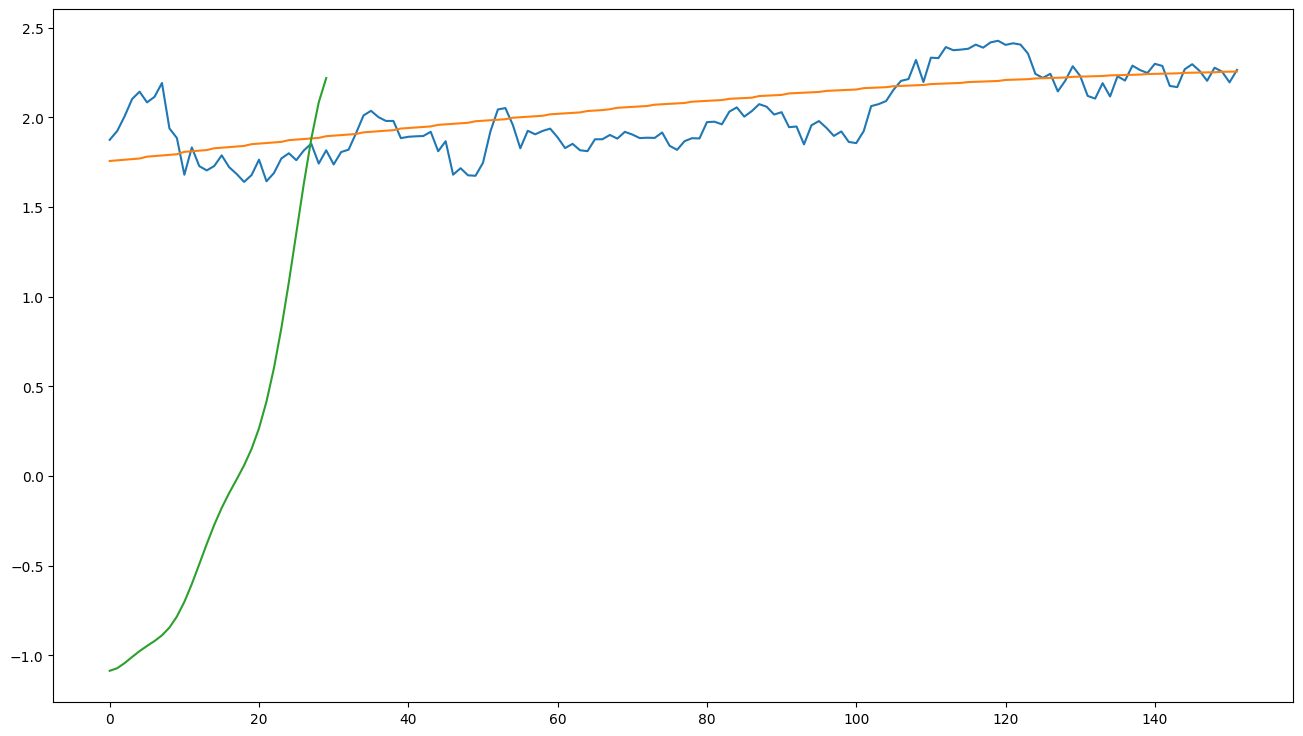

In [128]:
plt.figure(figsize=(16,9))
plt.plot(y_test)

plt.plot(model.predict(X_test))
plt.plot(model.predict(pred_30_date))

In [129]:
df_scaled

,Timestamp
2021-03-31 17:00,-1.675247
2021-03-31 18:00,-1.559712
2021-03-31 19:00,-1.444178
2021-03-31 20:00,-1.328644
2021-03-31 21:00,-1.213110
2021-03-31 22:00,-1.097575
2021-03-31 23:00,-0.982041
2021-04-01 00:00,-0.866507
2021-04-01 01:00,-0.750973
2021-04-01 02:00,-0.635438


array([[1.87475805],
       [1.92380228],
       [2.00636594],
       [2.10216095],
       [2.14326637],
       [2.08363706],
       [2.1143338 ],
       [2.19160492],
       [1.93844498],
       [1.88463746],
       [1.68016891],
       [1.83241771],
       [1.72797821],
       [1.70433818],
       [1.72868388],
       [1.78813677],
       [1.72233283],
       [1.68457936],
       [1.640122  ],
       [1.67805189],
       [1.76414391],
       [1.64365036],
       [1.68951906],
       [1.77120064],
       [1.79978036],
       [1.76132122],
       [1.81548157],
       [1.85305862],
       [1.74244449],
       [1.81636366],
       [1.73750478],
       [1.80666067],
       [1.81989203],
       [1.91215868],
       [2.01077639],
       [2.03653343],
       [2.00124981],
       [1.98007964],
       [1.98007964],
       [1.88410821],
       [1.89169418],
       [1.89434046],
       [1.89592822],
       [1.91956824],
       [1.81107112],
       [1.86699565],
       [1.68052174],
       [1.716